In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
path_results = Path('/media/discoD/models/elmo/ner/datalawyer')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/datalawyer/datalawyer-ft
/media/discoD/models/elmo/ner/datalawyer/harem_cnn.tar.gz
/media/discoD/models/elmo/ner/datalawyer/harem_glove.tar.gz
/media/discoD/models/elmo/ner/datalawyer/results_datalawyer.tar.gz


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    if folder.is_dir():
        results_model_folder = folder.iterdir()
        for training_folder in results_model_folder:
            #print('Reading files from %s' % training_folder.name)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[training_folder.name] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[training_folder.name] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % training_folder.name)
                metrics[training_folder.name] = None
print(len(metrics))
print(len(configs))

29
29


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, DOMAN_SPECIFIC, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Domain_Specific',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    if len(data) == 4:
        # GloVe e None
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: False, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        # GloVe Jur
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[2], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Invalid id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Domain_Specific,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_none_0_0,datalawyer,none,False,No,0,0,17,20,01:17:26,4646.0,232.30,0.995489,0.995697,0.949133,0.947429,0.948280,7.508642,0.988052,0.988348,0.879733,0.892319,0.885981,30.401057,0.985513,0.986112,0.834225,0.855799,0.844874,39.785256
1,datalawyer_cnn-no-elmo_0_0,datalawyer,cnn-no-elmo,False,No,0,0,19,20,00:19:12,1152.0,57.60,0.951460,0.955044,0.537929,0.492927,0.514446,126.334623,0.943054,0.946522,0.517570,0.472120,0.493801,159.389442,0.943054,0.946522,0.517570,0.472120,0.493801,159.389442
2,datalawyer_fasttext_cbow_jur_0_0,datalawyer,fasttext,True,cbow,0,0,14,20,01:22:34,4954.0,247.70,0.992319,0.992708,0.917529,0.911837,0.914674,11.156613,0.988625,0.989069,0.879412,0.900602,0.889881,22.052143,0.986024,0.986587,0.845455,0.874608,0.859784,30.901843
3,datalawyer_fasttext_cbow_jur_1_0,datalawyer,fasttext,True,cbow,1,0,14,20,01:18:35,4715.0,235.75,0.991632,0.991978,0.913086,0.909061,0.911069,11.824911,0.988329,0.988792,0.886551,0.888554,0.887552,25.105839,0.986323,0.986992,0.856255,0.863636,0.859930,33.842409
4,datalawyer_fasttext_cbow_jur_2_0,datalawyer,fasttext,True,cbow,2,0,17,20,01:21:59,4919.0,245.95,0.991609,0.991978,0.915271,0.910041,0.912648,11.527814,0.988588,0.988792,0.866762,0.911145,0.888399,22.213076,0.986094,0.986481,0.827535,0.876176,0.851161,32.149850
5,datalawyer_fasttext_skip_jur_0_0,datalawyer,fasttext,True,skip,0,0,12,20,01:19:57,4797.0,239.85,0.996208,0.996338,0.954501,0.955592,0.955046,6.357921,0.988736,0.989032,0.879527,0.896084,0.887728,30.257647,0.984510,0.985020,0.841660,0.858150,0.849825,45.842382
6,datalawyer_fasttext_skip_jur_1_0,datalawyer,fasttext,True,skip,1,0,8,20,01:20:22,4822.0,241.10,0.996273,0.996438,0.956742,0.956898,0.956820,6.263696,0.988274,0.988533,0.885971,0.889307,0.887636,27.520518,0.986904,0.987361,0.855385,0.871473,0.863354,36.415931
7,datalawyer_fasttext_skip_jur_2_0,datalawyer,fasttext,True,skip,2,0,11,20,01:22:23,4943.0,247.15,0.996127,0.996323,0.955131,0.955755,0.955443,6.146752,0.988237,0.988681,0.889650,0.880271,0.884936,31.591052,0.984985,0.985566,0.862589,0.851097,0.856805,43.570426
8,datalawyer_glove-no-elmo_0_0,datalawyer,glove-no-elmo,False,No,0,0,16,20,00:18:01,1081.0,54.05,0.992881,0.993328,0.913743,0.914634,0.914188,24.969087,0.969171,0.971122,0.730153,0.730885,0.730519,152.411168,0.969171,0.971122,0.730153,0.730885,0.730519,152.411168
9,datalawyer_glove_0_0,datalawyer,glove,False,No,0,0,18,20,01:19:37,4777.0,238.85,0.996377,0.996523,0.959837,0.959837,0.959837,6.021274,0.987497,0.987867,0.893048,0.880271,0.886614,37.799094,0.987203,0.987643,0.866092,0.866771,0.866432,44.499107


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:16:07.068966'

In [12]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
cbow,9.0,0.857361,0.004180,0.851161,0.853640,0.859574,0.859915,0.862150
skip,9.0,0.855378,0.004092,0.849825,0.852201,0.856362,0.856805,0.863354
No,11.0,0.810628,0.111718,0.493801,0.845843,0.850406,0.857312,0.866926


In [13]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,6.0,0.857402,0.007749,0.850038,0.850922,0.855306,0.864359,0.866926
fasttext,6.0,0.856810,0.005331,0.849825,0.852572,0.858295,0.859893,0.863354
wang2vec,6.0,0.856163,0.003981,0.850898,0.853952,0.855686,0.858310,0.862150
word2vec,6.0,0.856137,0.003696,0.851179,0.853241,0.856975,0.859078,0.859915
none,3.0,0.849390,0.006220,0.844874,0.845843,0.846812,0.851648,0.856485
glove-no-elmo,1.0,0.730519,NaN,0.730519,0.730519,0.730519,0.730519,0.730519
cnn-no-elmo,1.0,0.493801,NaN,0.493801,0.493801,0.493801,0.493801,0.493801


In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,cbow,3.0,0.858236,0.004296,0.853640,0.856280,0.858920,0.860535,0.862150
glove,No,6.0,0.857402,0.007749,0.850038,0.850922,0.855306,0.864359,0.866926
fasttext,cbow,3.0,0.856958,0.005021,0.851161,0.855473,0.859784,0.859857,0.859930
word2vec,cbow,3.0,0.856889,0.004948,0.851179,0.855377,0.859574,0.859745,0.859915
fasttext,skip,3.0,0.856661,0.006765,0.849825,0.853315,0.856805,0.860079,0.863354
word2vec,skip,3.0,0.855384,0.002823,0.852201,0.854282,0.856362,0.856975,0.857588
wang2vec,skip,3.0,0.854090,0.002877,0.850898,0.852894,0.854890,0.855686,0.856481
none,No,3.0,0.849390,0.006220,0.844874,0.845843,0.846812,0.851648,0.856485
glove-no-elmo,No,1.0,0.730519,NaN,0.730519,0.730519,0.730519,0.730519,0.730519


In [15]:
training_data_df.groupby([EMBEDDING, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Domain_Specific,,,,,,,,
glove,False,3.0,0.858326,0.008015,0.850406,0.854273,0.858140,0.862286,0.866432
fasttext,True,6.0,0.856810,0.005331,0.849825,0.852572,0.858295,0.859893,0.863354
glove,True,3.0,0.856479,0.009129,0.850038,0.851255,0.852472,0.859699,0.866926
wang2vec,True,6.0,0.856163,0.003981,0.850898,0.853952,0.855686,0.858310,0.862150
word2vec,True,6.0,0.856137,0.003696,0.851179,0.853241,0.856975,0.859078,0.859915
none,False,3.0,0.849390,0.006220,0.844874,0.845843,0.846812,0.851648,0.856485
glove-no-elmo,False,1.0,0.730519,NaN,0.730519,0.730519,0.730519,0.730519,0.730519
cnn-no-elmo,False,1.0,0.493801,NaN,0.493801,0.493801,0.493801,0.493801,0.493801


In [16]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,Domain_Specific,,,,,,,,
glove,No,False,3.0,0.858326,0.008015,0.850406,0.854273,0.858140,0.862286,0.866432
wang2vec,cbow,True,3.0,0.858236,0.004296,0.853640,0.856280,0.858920,0.860535,0.862150
fasttext,cbow,True,3.0,0.856958,0.005021,0.851161,0.855473,0.859784,0.859857,0.859930
word2vec,cbow,True,3.0,0.856889,0.004948,0.851179,0.855377,0.859574,0.859745,0.859915
fasttext,skip,True,3.0,0.856661,0.006765,0.849825,0.853315,0.856805,0.860079,0.863354
glove,No,True,3.0,0.856479,0.009129,0.850038,0.851255,0.852472,0.859699,0.866926
word2vec,skip,True,3.0,0.855384,0.002823,0.852201,0.854282,0.856362,0.856975,0.857588
wang2vec,skip,True,3.0,0.854090,0.002877,0.850898,0.852894,0.854890,0.855686,0.856481
none,No,False,3.0,0.849390,0.006220,0.844874,0.845843,0.846812,0.851648,0.856485


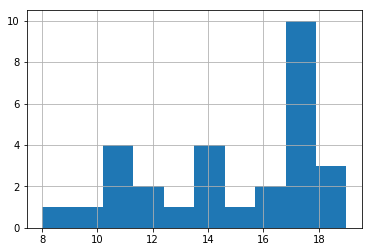

In [17]:
training_data_df[BEST_EPOCH].hist()

In [18]:
training_data_df[TOTAL_DURATION].describe()

count      29.000000
mean     4567.068966
std       962.374331
min      1081.000000
25%      4715.000000
50%      4777.000000
75%      4943.000000
max      5031.000000
Name: Total_Duration(s), dtype: float64

In [19]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
2,9.0,0.855516,0.003564,0.851161,0.852472,0.856362,0.856805,0.862150
1,9.0,0.854133,0.005599,0.846812,0.850406,0.852201,0.859915,0.863354
0,11.0,0.813157,0.112770,0.493801,0.847350,0.857588,0.859679,0.866926


In [20]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,29.0,0.839019,0.070555,0.013102,0.812181,0.865857


In [21]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
datalawyer,29,0.839019,0.070555,0.013102,0.81334,0.864699


In [22]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:151: RuntimeWarning: invalid value encountered in double_scalars
  l_ci = lambda x: numpy.mean(x) - (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))
/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:154: RuntimeWarning: invalid value encountered in double_scalars
  u_ci = lambda x: numpy.mean(x) + (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))


,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
cnn-no-elmo,1,0.493801,NaN,NaN,NaN,NaN
fasttext,6,0.856810,0.005331,0.002176,0.852544,0.861076
glove,6,0.857402,0.007749,0.003164,0.851201,0.863603
glove-no-elmo,1,0.730519,NaN,NaN,NaN,NaN
none,3,0.849390,0.006220,0.003591,0.842352,0.856429
wang2vec,6,0.856163,0.003981,0.001625,0.852977,0.859349
word2vec,6,0.856137,0.003696,0.001509,0.853179,0.859094


In [23]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  Interval
Model      Embedding                                                          
datalawyer cnn-no-elmo    1  0.493801       NaN       NaN        NaN       NaN
           fasttext       6  0.856810  0.005331  0.002176   0.852544  0.861076
           glove          6  0.857402  0.007749  0.003164   0.851201  0.863603
           glove-no-elmo  1  0.730519       NaN       NaN        NaN       NaN
           none           3  0.849390  0.006220  0.003591   0.842352  0.856429
           wang2vec       6  0.856163  0.003981  0.001625   0.852977  0.859349
           word2vec       6  0.856137  0.003696  0.001509   0.853179  0.859094

In [24]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 6, 22) =  762.222, p =  0.00000000000000000000
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     762.2
Date:                Tue, 21 May 2019   Prob (F-statistic):           2.34e-24
Time:                        08:53:00   Log-Likelihood:                 113.70
No. Observations:                  29   AIC:                            -213.4
Df Residuals:                      22   BIC:                            -203.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------